# Brain Tumor Classification with [Tensorflow]
### Dataset - https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset/download
#### Rana Karmakar
##### National Skill Training Institute, Bhubaneswar

## Required Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

## Downloading The Dataset

In [ ]:
!export KAGGLE_USERNAME="ranaslifestyle" && export KAGGLE_KEY="fee49541cef36b609a252e86ff60e5c3" && kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip brain-tumor-mri-dataset.zip

Archive:  brain-tumor-mri-dataset.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Testing/glioma/Te-glTr_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

brain-tumor-mri-dataset.zip  cnn_model.h5  Testing
cleaned			     sample_data   Training


## Image Count

In [ ]:
image_count = len('/content/Training/glioma')
print(image_count)

24


# Image Preprocessing

In [ ]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	
if __name__ == "__main__":
	training = "/content/Training"
	testing = "/content/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

## Create a dataset

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/cleaned/Training",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/cleaned/Testing",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1311 files belonging to 4 classes.
Using 262 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


## Visualize the data

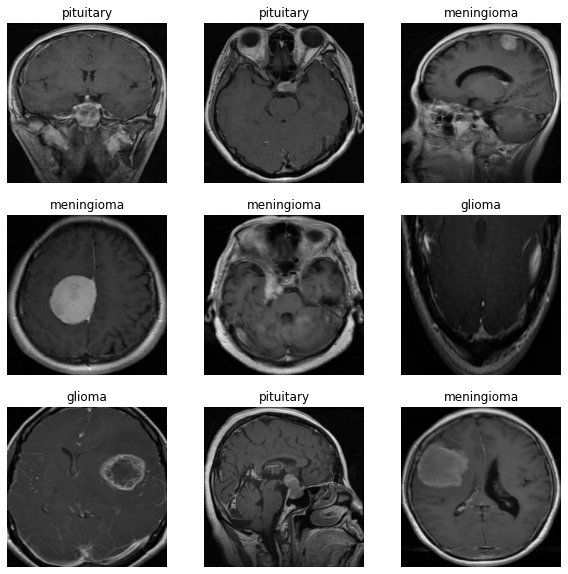

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96470594


## Create the model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Train the model

In [ ]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/150
143/143 [==============================] - 15s 88ms/step - loss: 0.8430 - accuracy: 0.6512 - val_loss: 0.7143 - val_accuracy: 0.7328
Epoch 2/150
143/143 [==============================] - 11s 79ms/step - loss: 0.4478 - accuracy: 0.8269 - val_loss: 0.4715 - val_accuracy: 0.8130
Epoch 3/150
143/143 [==============================] - 11s 77ms/step - loss: 0.2817 - accuracy: 0.8996 - val_loss: 0.3914 - val_accuracy: 0.8321
Epoch 4/150
143/143 [==============================] - 11s 78ms/step - loss: 0.1547 - accuracy: 0.9435 - val_loss: 0.3542 - val_accuracy: 0.9008
Epoch 5/150
143/143 [==============================] - 11s 79ms/step - loss: 0.0770 - accuracy: 0.9768 - val_loss: 0.3587 - val_accuracy: 0.9008
Epoch 6/150
143/143 [==============================] - 12s 85ms/step - loss: 0.0379 - accuracy: 0.9895 - val_loss: 0.4619 - val_accuracy: 0.8931
Epoch 7/150
143/143 [==============================] - 11s 79ms/step - loss: 0.0463 - accuracy: 0.9847 - val_loss: 0.4585 - val_ac

## Visualize training results

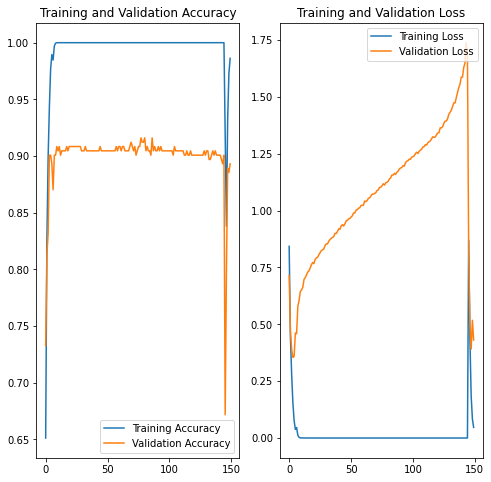

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

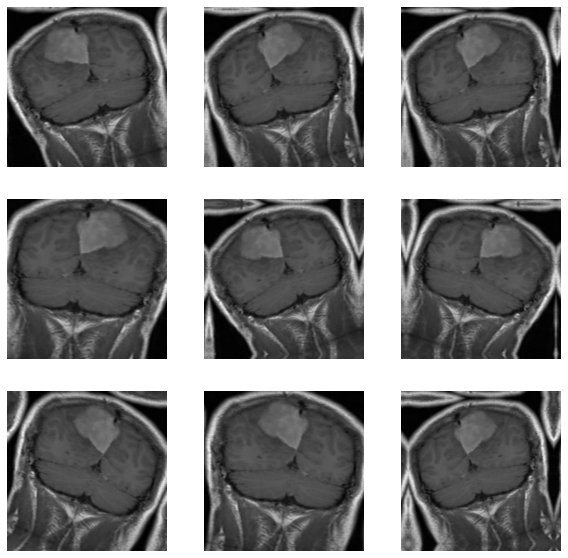

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/150
143/143 [==============================] - 14s 90ms/step - loss: 1.3475 - accuracy: 0.3694 - val_loss: 0.9337 - val_accuracy: 0.5916
Epoch 2/150
143/143 [==============================] - 13s 88ms/step - loss: 0.8509 - accuracy: 0.6497 - val_loss: 0.7374 - val_accuracy: 0.7176
Epoch 3/150
143/143 [==============================] - 13s 89ms/step - loss: 0.7022 - accuracy: 0.7298 - val_loss: 0.6810 - val_accuracy: 0.7519
Epoch 4/150
143/143 [==============================] - 13s 89ms/step - loss: 0.6240 - accuracy: 0.7571 - val_loss: 0.6224 - val_accuracy: 0.7710
Epoch 5/150
143/143 [==============================] - 13s 89ms/step - loss: 0.5786 - accuracy: 0.7836 - val_loss: 0.6483 - val_accuracy: 0.7824
Epoch 6/150
143/143 [==============================] - 13s 88ms/step - loss: 0.5527 - accuracy: 0.7853 - val_loss: 0.7172 - val_accuracy: 0.7252
Epoch 7/150
143/143 [==============================] - 13s 89ms/step - loss: 0.4861 - accuracy: 0.8206 - val_loss: 0.6646 - val_ac

## Visualize training results

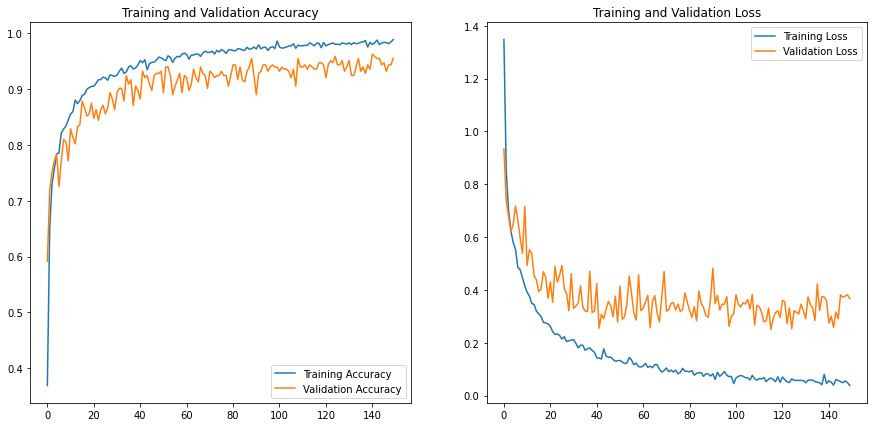

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("Accuracy.png")

## Predict on new data

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/cleaned/Testing/notumor/Te-noTr_0000.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

 notumor with a 99.90 


In [ ]:
model.save('cnn_model.h5')